In [2]:
pip install opencv-python numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python numpy matplotlib ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Please enter the path to the larger image:  Desktop/Research Group_Software/Kaleb - CCS/ARMCO/ARM1-8/ARM1-8 whole slide BSE.tif
Please enter the path to the smaller image:  Desktop/Research Group_Software/Kaleb - CCS/Mt Simon Sandstone/SEM-QEMSCAN/Armco well/ARMCO QEMSCAN_No Border/ARM1-8_ field 1_RGB.png
Please enter the folder path where the output image should be saved:  Desktop/Research Group_Software/Kaleb - CCS/ARMCO/Located Images Test


Output image saved at: Desktop/Research Group_Software/Kaleb - CCS/ARMCO/Located Images Test\matched_image.png


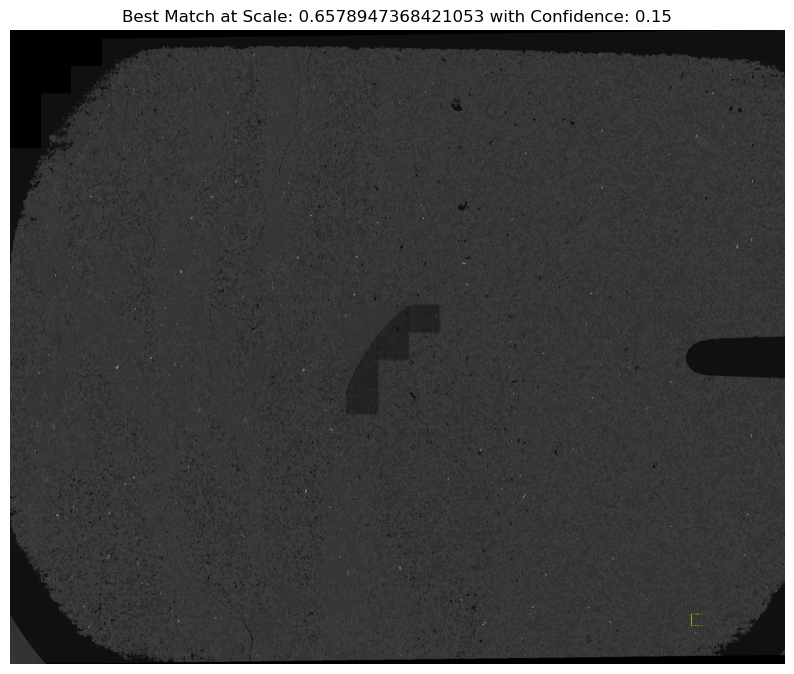

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to read the image from a specified path
def load_image_from_path(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image from path: {image_path}")
    return image

# Function to ensure the save directory exists
def ensure_directory_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

# Function to perform multi-scale template matching
def multi_scale_template_matching(large_image, small_image, scales=np.linspace(0.5, 1.5, 20)):
    best_scale = None
    best_match = None
    best_val = -np.inf
    best_top_left = None
    best_bottom_right = None

    # Loop over each scale
    for scale in scales:
        # Resize the smaller image according to the current scale
        resized_small_image = cv2.resize(small_image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        
        if resized_small_image.shape[0] > large_image.shape[0] or resized_small_image.shape[1] > large_image.shape[1]:
            continue  # Skip if the resized template is larger than the image

        # Convert both images to grayscale
        large_gray = cv2.cvtColor(large_image, cv2.COLOR_BGR2GRAY)
        small_gray = cv2.cvtColor(resized_small_image, cv2.COLOR_BGR2GRAY)
        
        # Perform template matching
        result = cv2.matchTemplate(large_gray, small_gray, cv2.TM_CCOEFF_NORMED)
        
        # Find the best match for the current scale
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        
        if max_val > best_val:
            best_val = max_val
            best_scale = scale
            best_top_left = max_loc
            best_bottom_right = (best_top_left[0] + resized_small_image.shape[1], best_top_left[1] + resized_small_image.shape[0])
            best_match = resized_small_image

    return best_top_left, best_bottom_right, best_scale, best_val

# Prompt the user to input the file paths for the larger and smaller images
large_image_path = input("Please enter the path to the larger image: ")
small_image_path = input("Please enter the path to the smaller image: ")

# Prompt the user to input the folder path to save the result image
save_directory = input("Please enter the folder path where the output image should be saved: ")
ensure_directory_exists(save_directory)

# Specify the name of the output image
output_image_name = "matched_image.png"
output_image_path = os.path.join(save_directory, output_image_name)

# Load the images
large_image = load_image_from_path(large_image_path)
small_image = load_image_from_path(small_image_path)

# Perform multi-scale template matching
best_top_left, best_bottom_right, best_scale, best_val = multi_scale_template_matching(large_image, small_image)

# Draw a yellow rectangle around the entire matched area
output_image = large_image.copy()
cv2.rectangle(output_image, best_top_left, best_bottom_right, (0, 255, 255), thickness=5)

# Save the resulting image to the specified folder
cv2.imwrite(output_image_path, output_image)
print(f"Output image saved at: {output_image_path}")

# Convert image to RGB for display (OpenCV uses BGR by default)
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Display the result using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(output_image_rgb)
plt.title(f'Best Match at Scale: {best_scale} with Confidence: {best_val:.2f}')
plt.axis('off')
plt.show()


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to read the image from a specified path
def load_image_from_path(image_path, as_gray=False):
    if as_gray:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image from path: {image_path}")
    return image

# Function to ensure the save directory exists
def ensure_directory_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

# Function to perform feature matching using ORB and KNN
def feature_matching_with_knn(large_image, small_image):
    # Initiate ORB detector
    orb = cv2.ORB_create()

    # Find keypoints and descriptors with ORB for both images
    kp1, des1 = orb.detectAndCompute(small_image, None)
    kp2, des2 = orb.detectAndCompute(large_image, None)

    # Create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    # KNN Match descriptors.
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    return kp1, kp2, good_matches

# Function to find the homography and draw matches
def find_homography_and_draw(large_image, small_image, kp1, kp2, good_matches, save_path):
    if len(good_matches) > 4:  # Minimum number of matches required for homography
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Get the dimensions of the smaller image
        h, w = small_image.shape[:2]
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

        # Project the corners of the smaller image onto the larger image
        dst = cv2.perspectiveTransform(pts, M)

        # Draw lines around the matched region
        large_image_with_match = cv2.polylines(large_image.copy(), [np.int32(dst)], True, (0, 255, 255), 3, cv2.LINE_AA)

        # Save the result
        cv2.imwrite(save_path, large_image_with_match)
        print(f"Output image saved at: {save_path}")

        # Display the matched image
        output_image_rgb = cv2.cvtColor(large_image_with_match, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(output_image_rgb)
        plt.title('Matched Region Highlighted')
        plt.axis('off')
        plt.show()
    else:
        print("Not enough matches were found - {}/{}".format(len(good_matches), 4))

# Prompt the user to input the file paths for the larger and smaller images
large_image_path = input("Please enter the path to the larger (grayscale) image: ")
small_image_path = input("Please enter the path to the smaller (RGB) image: ")

# Prompt the user to input the folder path to save the result image
save_directory = input("Please enter the folder path where the output image should be saved: ")
ensure_directory_exists(save_directory)

# Specify the name of the output image
output_image_name = "matched_image.png"
output_image_path = os.path.join(save_directory, output_image_name)

# Load the images
large_image = load_image_from_path(large_image_path, as_gray=True)  # Grayscale image
small_image = load_image_from_path(small_image_path)  # RGB image

# Convert smaller RGB image to grayscale
small_image_gray = cv2.cvtColor(small_image, cv2.COLOR_BGR2GRAY)

# Perform KNN-based feature matching
kp1, kp2, good_matches = feature_matching_with_knn(large_image, small_image_gray)

# Find homography and draw matched region
find_homography_and_draw(large_image, small_image, kp1, kp2, good_matches, output_image_path)


Please enter the path to the larger (grayscale) image:  Desktop/Research Group_Software/Kaleb - CCS/ARMCO/ARM1-8/ARM1-8 whole slide BSE.tif
Please enter the path to the smaller (RGB) image:  Desktop/Research Group_Software/Kaleb - CCS/Mt Simon Sandstone/SEM-QEMSCAN/Armco well/ARMCO QEMSCAN_No Border/ARM1-8_ field 1_RGB.png
Please enter the folder path where the output image should be saved:  Desktop/Research Group_Software/Kaleb - CCS/ARMCO/Located Images Test


Not enough matches were found - 0/4


Please enter the path to the larger (grayscale) image:  Desktop/Research Group_Software/Kaleb - CCS/ARMCO/ARM1-8/ARM1-8 whole slide BSE.tif
Please enter the path to the smaller (RGB) image:  Desktop/Research Group_Software/Kaleb - CCS/Mt Simon Sandstone/SEM-QEMSCAN/Armco well/ARMCO QEMSCAN_No Border/ARM1-8_ field 1_RGB.png
Please enter the folder path where the output image should be saved:  Desktop/Research Group_Software/Kaleb - CCS/ARMCO/Located Images Test


Output image saved at: Desktop/Research Group_Software/Kaleb - CCS/ARMCO/Located Images Test\matched_image.png


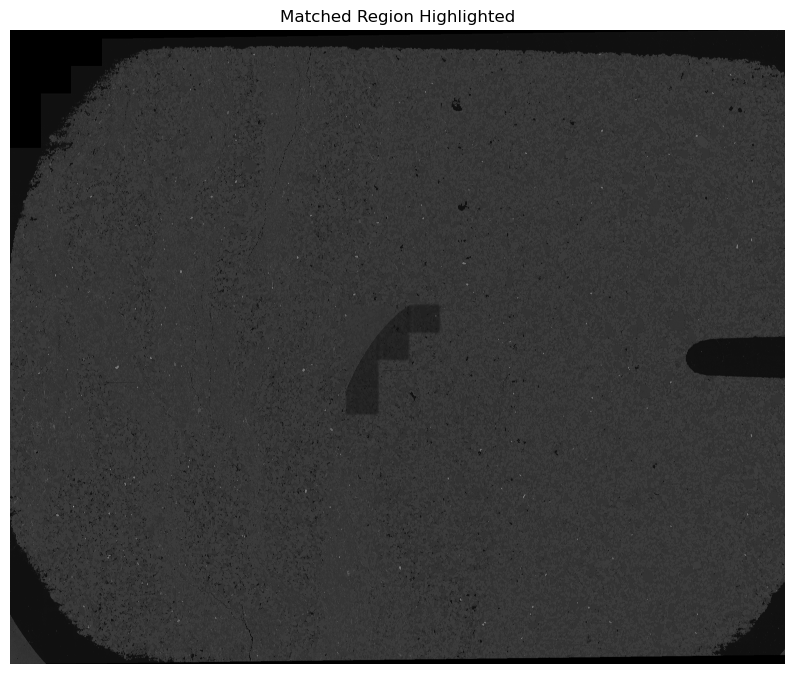

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to read the image from a specified path
def load_image_from_path(image_path, as_gray=False):
    if as_gray:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image from path: {image_path}")
    return image

# Function to ensure the save directory exists
def ensure_directory_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

# Function to perform feature matching using ORB and FLANN
def feature_matching_with_flann(large_image, small_image):
    # Initiate ORB detector
    orb = cv2.ORB_create(nfeatures=10000)  # Increase the number of features

    # Find keypoints and descriptors with ORB for both images
    kp1, des1 = orb.detectAndCompute(small_image, None)
    kp2, des2 = orb.detectAndCompute(large_image, None)

    # FLANN parameters
    index_params = dict(algorithm=6,  # FLANN_INDEX_LSH
                        table_number=6,  # 12
                        key_size=12,  # 20
                        multi_probe_level=1)  # 2
    search_params = dict(checks=50)  # Increase the number of checks for more robustness

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using KNN with FLANN
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    return kp1, kp2, good_matches

# Function to find the homography and draw matches
def find_homography_and_draw(large_image, small_image, kp1, kp2, good_matches, save_path):
    if len(good_matches) > 4:  # Minimum number of matches required for homography
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Get the dimensions of the smaller image
        h, w = small_image.shape[:2]
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

        # Project the corners of the smaller image onto the larger image
        dst = cv2.perspectiveTransform(pts, M)

        # Draw lines around the matched region
        large_image_with_match = cv2.polylines(large_image.copy(), [np.int32(dst)], True, (0, 255, 255), 3, cv2.LINE_AA)

        # Save the result
        cv2.imwrite(save_path, large_image_with_match)
        print(f"Output image saved at: {save_path}")

        # Display the matched image
        output_image_rgb = cv2.cvtColor(large_image_with_match, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(output_image_rgb)
        plt.title('Matched Region Highlighted')
        plt.axis('off')
        plt.show()
    else:
        print(f"Not enough matches were found - {len(good_matches)}/4")

# Prompt the user to input the file paths for the larger and smaller images
large_image_path = input("Please enter the path to the larger (grayscale) image: ")
small_image_path = input("Please enter the path to the smaller (RGB) image: ")

# Prompt the user to input the folder path to save the result image
save_directory = input("Please enter the folder path where the output image should be saved: ")
ensure_directory_exists(save_directory)

# Specify the name of the output image
output_image_name = "matched_image.png"
output_image_path = os.path.join(save_directory, output_image_name)

# Load the images
large_image = load_image_from_path(large_image_path, as_gray=True)  # Grayscale image
small_image = load_image_from_path(small_image_path)  # RGB image

# Convert smaller RGB image to grayscale
small_image_gray = cv2.cvtColor(small_image, cv2.COLOR_BGR2GRAY)

# Perform FLANN-based feature matching
kp1, kp2, good_matches = feature_matching_with_flann(large_image, small_image_gray)

# Find homography and draw matched region
find_homography_and_draw(large_image, small_image, kp1, kp2, good_matches, output_image_path)


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to read the image from a specified path
def load_image_from_path(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image from path: {image_path}")
    return image

# Function to ensure the save directory exists
def ensure_directory_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

# Function to convert image to grayscale if it's in color
def convert_to_grayscale(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        # Image is in color (RGB), convert to grayscale
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Image is already grayscale
    return image

# Function to perform feature matching using ORB and FLANN
def feature_matching_with_flann(large_image_gray, small_image_gray):
    # Initiate ORB detector
    orb = cv2.ORB_create(nfeatures=10000)  # Increase the number of features

    # Find keypoints and descriptors with ORB for both images
    kp1, des1 = orb.detectAndCompute(small_image_gray, None)
    kp2, des2 = orb.detectAndCompute(large_image_gray, None)

    # FLANN parameters
    index_params = dict(algorithm=6,  # FLANN_INDEX_LSH
                        table_number=6,  # 12
                        key_size=12,  # 20
                        multi_probe_level=1)  # 2
    search_params = dict(checks=50)  # Increase the number of checks for more robustness

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using KNN with FLANN
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    return kp1, kp2, good_matches

# Function to find the homography and draw matches
def find_homography_and_draw(large_image, small_image, kp1, kp2, good_matches, save_path):
    if len(good_matches) > 4:  # Minimum number of matches required for homography
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Get the dimensions of the smaller image
        h, w = small_image.shape[:2]
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

        # Project the corners of the smaller image onto the larger image
        dst = cv2.perspectiveTransform(pts, M)

        # Draw lines around the matched region
        large_image_with_match = cv2.polylines(large_image.copy(), [np.int32(dst)], True, (0, 255, 255), 3, cv2.LINE_AA)

        # Save the result
        cv2.imwrite(save_path, large_image_with_match)
        print(f"Output image saved at: {save_path}")

        # Display the matched image
        output_image_rgb = cv2.cvtColor(large_image_with_match, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(output_image_rgb)
        plt.title('Matched Region Highlighted')
        plt.axis('off')
        plt.show()
    else:
        print(f"Not enough matches were found - {len(good_matches)}/4")

# Prompt the user to input the file paths for the larger and smaller images
large_image_path = input("Please enter the path to the larger image (grayscale or color): ")
small_image_path = input("Please enter the path to the smaller image (grayscale or color): ")

# Prompt the user to input the folder path to save the result image
save_directory = input("Please enter the folder path where the output image should be saved: ")
ensure_directory_exists(save_directory)

# Specify the name of the output image
output_image_name = "matched_image.png"
output_image_path = os.path.join(save_directory, output_image_name)

# Load the images (both grayscale or color)
large_image = load_image_from_path(large_image_path)  # Could be grayscale or RGB
small_image = load_image_from_path(small_image_path)  # Could be grayscale or RGB

# Convert both images to grayscale if they are in color
large_image_gray = convert_to_grayscale(large_image)
small_image_gray = convert_to_grayscale(small_image)

# Perform FLANN-based feature matching
kp1, kp2, good_matches = feature_matching_with_flann(large_image_gray, small_image_gray)

# Find homography and draw matched region
find_homography_and_draw(large_image, small_image, kp1, kp2, good_matches, output_image_path)


Please enter the path to the larger image (grayscale or color):  Desktop/Research Group_Software/Kaleb - CCS/ARMCO/ARM1-8/ARM1-8 whole slide BSE.tif
Please enter the path to the smaller image (grayscale or color):  Desktop/Research Group_Software/Kaleb - CCS/Mt Simon Sandstone/SEM-QEMSCAN/Armco BSE as bmp/Kalebs selections/arm1-8, field 1.bmp
Please enter the folder path where the output image should be saved:  Desktop/Research Group_Software/Kaleb - CCS/ARMCO/Located Images Test


Not enough matches were found - 4/4


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to read the image from a specified path
def load_image_from_path(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image from path: {image_path}")
    return image

# Function to ensure the save directory exists
def ensure_directory_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

# Function to convert image to grayscale if it's in color
def convert_to_grayscale(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        # Image is in color (RGB), convert to grayscale
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Image is already grayscale
    return image

# Function to perform feature matching using SIFT and FLANN
def feature_matching_with_flann(large_image_gray, small_image_gray):
    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors with SIFT for both images
    kp1, des1 = sift.detectAndCompute(small_image_gray, None)
    kp2, des2 = sift.detectAndCompute(large_image_gray, None)

    # FLANN parameters
    index_params = dict(algorithm=1, trees=5)  # FLANN_INDEX_KDTREE is algorithm 1
    search_params = dict(checks=100)  # Increase the number of checks for more robustness

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using KNN with FLANN
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    return kp1, kp2, good_matches

# Function to find the homography and draw matches
def find_homography_and_draw(large_image, small_image, kp1, kp2, good_matches, save_path):
    if len(good_matches) > 4:  # Minimum number of matches required for homography
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Get the dimensions of the smaller image
        h, w = small_image.shape[:2]
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

        # Project the corners of the smaller image onto the larger image
        dst = cv2.perspectiveTransform(pts, M)

        # Draw a yellow rectangle around the detected small image
        large_image_with_match = cv2.polylines(large_image.copy(), [np.int32(dst)], True, (0, 255, 255), 3, cv2.LINE_AA)

        # Save the result
        cv2.imwrite(save_path, large_image_with_match)
        print(f"Output image saved at: {save_path}")

        # Display the matched image
        output_image_rgb = cv2.cvtColor(large_image_with_match, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(output_image_rgb)
        plt.title('Matched Region Highlighted')
        plt.axis('off')
        plt.show()
    else:
        print(f"Not enough matches were found - {len(good_matches)}/4")

# Prompt the user to input the file paths for the larger and smaller images
large_image_path = input("Please enter the path to the larger image (grayscale or color): ")
small_image_path = input("Please enter the path to the smaller image (grayscale or color): ")

# Prompt the user to input the folder path to save the result image
save_directory = input("Please enter the folder path where the output image should be saved: ")
ensure_directory_exists(save_directory)

# Specify the name of the output image
output_image_name = "matched_image.png"
output_image_path = os.path.join(save_directory, output_image_name)

# Load the images (both grayscale or color)
large_image = load_image_from_path(large_image_path)  # Could be grayscale or RGB
small_image = load_image_from_path(small_image_path)  # Could be grayscale or RGB

# Convert both images to grayscale if they are in color
large_image_gray = convert_to_grayscale(large_image)
small_image_gray = convert_to_grayscale(small_image)

# Perform FLANN-based feature matching with SIFT
kp1, kp2, good_matches = feature_matching_with_flann(large_image_gray, small_image_gray)

# Find homography and draw matched region
find_homography_and_draw(large_image, small_image, kp1, kp2, good_matches, output_image_path)


Please enter the path to the larger image (grayscale or color):  Desktop/Research Group_Software/Kaleb - CCS/ARMCO/ARM1-8/ARM1-8 whole slide BSE.tif
Please enter the path to the smaller image (grayscale or color):  Desktop/Research Group_Software/Kaleb - CCS/Mt Simon Sandstone/SEM-QEMSCAN/Armco BSE as bmp/Kalebs selections/arm1-8, field 1.bmp
Please enter the folder path where the output image should be saved:  Desktop/Research Group_Software/Kaleb - CCS/ARMCO/Located Images Test
